In [1]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext rpy2.ipython

In [5]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/vocal_synthesis"
data_folder = os.environ["DATA_DIR"]

In [8]:

ctr = np.load(data_folder + os.path.sep + "x0.5_6_all_offset2_fft.npy.npz.sample")
X_train = ctr.reshape( (1, X_train.shape[0], X_train.shape[1]))
X_train.shape

(1, 12, 16000)

In [9]:
args = dict()
args["seed"] = 0
args["batch_size"] = 128
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 4000
args["X_train"] = X_train
args["X_valid"] = X_train
args["X_test"] = X_train
args["update_method"] = rmsprop
#args["out_pkl"] = out_pkl
args["units"] = [2000]
args["out_nonlinearity"] = "sigmoid"

args["config"] = "../configurations/19mar_variable_3.py"

In [10]:
sys.path.append("..")
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + \
          "x0.5_12_all_offset3_fft/19mar_2000x1_sigmout.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19mar_variable_3.py
test...
using sigmout out nonlinearity
Number of params in model: 176034000
<lasagne.layers.input.InputLayer object at 0x112a751d0>,(None, None, 16000)
<lasagne.layers.recurrent.LSTMLayer object at 0x112cc14d0>,(None, None, 2000)
<lasagne.layers.shape.ReshapeLayer object at 0x112cc1490>,(None, 2000)
<lasagne.layers.dense.DenseLayer object at 0x112a55a90>,(None, 16000)
<lasagne.layers.shape.ReshapeLayer object at 0x11c7ed050>,(None, None, 16000)


In [11]:
# real min, real max, imag min, imag max = -12138885.000000, 12214989.000000, -12082921.000000, 12082921.000000
real_min = -12138885.000000
real_max = 12214989.000000
imag_min = -12082921.000000
imag_max = 12082921.000000

In [12]:
x_size = 8000

In [14]:
generated_seq = X_train[0:1].flatten().tolist()
generated_seq_array = []
# x1, x2, ..., x40
for i in range(0, X_train.shape[1]):
    generated_seq_array.append(X_train[0:1, i, :][0])
ctr = 0
for x in range(0, 30):
    #this_input = np.asarray(generated_seq_array[ctr::])
    this_input = np.asarray(generated_seq_array) # since we have var sequence lengths now
    this_input = this_input.reshape( (1, this_input.shape[0], this_input.shape[1]))
    
    #print this_input.shape
    #assert this_input.shape == (1, 100, 800)
    
    # (1, 40, 4000) -> (40, 4000) -> get last elem
    # predict x2, x3, ..., x41
    # then append x41 to generated_seq_array
    # now next time, feed [x2, x3, ..., x41] to out_fn to get
    # [x3, x4, ... x42]
    this_out = out_fn(this_input)[0][-1]
    assert this_out.shape == (x_size*2,)
    #print this_out.shape
    
    generated_seq_array.append(this_out)
    
    ctr += 1

In [15]:
len(generated_seq_array)

42

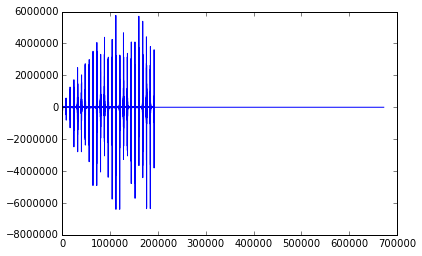

In [16]:
plt.plot(np.asarray(generated_seq_array).flatten())

In [17]:
new_generated_seq_array = []
for i in range(0, len(generated_seq_array)):
    this_seq = np.array(generated_seq_array[i], copy=True)
    # unnormalise the real elements
    this_seq[0:x_size] = (this_seq[0:x_size]*(real_max-real_min)) + real_min
    # unnormalise the imaginary elements
    this_seq[x_size::] = (this_seq[x_size::]*(imag_max-imag_min)) + imag_min
    # now do the inverse fft transform
    new_generated_seq_array.append( scipy.ifft(this_seq[0:x_size] + 1j*this_seq[x_size::]).real )

At least the original audio sounds correct still...

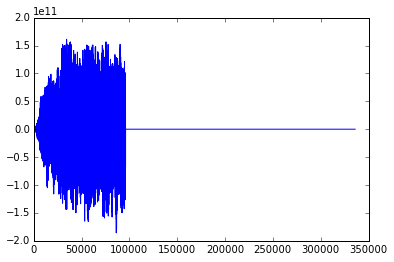

In [18]:
new_generated_seq = np.asarray(new_generated_seq_array).flatten()
plt.plot(new_generated_seq)

In [62]:
out_file = "/tmp/24mar_generated_2.wav"
wavfile.write(filename=out_file, rate=fs, data=new_generated_seq.astype("int16"))

----

In [2]:
x_size=8000

In [6]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
print data.dtype
data = np.asarray(data, dtype="float32")

int16


In [28]:
dm = np.hstack( (scipy.fft( data[0:8000] ).real, scipy.fft( data[0:8000] ).imag) )  / x_size
np.min(dm), np.max(dm)

(-100.79158221825649, 100.791582218256)

In [39]:
np.mean(dm)

-3.552713678800501e-18

already normalised...

In [32]:
print X_train[0][0]
print X_train[0][0].shape

[ 0.49813542  0.49813661  0.49813262 ...,  0.50000536  0.50000119
  0.49999604]
(16000,)


unnormalise...

In [33]:
unnorm = np.hstack((
    (X_train[0][0][0:x_size]*(real_max-real_min)) + real_min,
    (X_train[0][0][x_size::]*(imag_max-imag_min)) + imag_min
))
print unnorm
print unnorm.shape

[-7358. -7329. -7426. ...,   130.    29.   -96.]
(16000,)


Great, now do the inverse FFT and grab the real vector

In [34]:
scipy.ifft( unnorm[0:x_size] + 1j*unnorm[x_size::] ).real

array([  6.25000000e-03,   5.16054422e-04,  -8.41184349e-03, ...,
        -6.92997689e+02,  -7.40992634e+02,  -7.31005111e+02])

----

In [100]:
print data[0:int(16000*0.125)]
print len(data[0:int(16000*0.125)])

[ 0.  0.  0. ...,  5.  6.  7.]
2000


What happens when we do the fft on the first element of the training set

In [22]:
ff = np.hstack((
    scipy.fft( data[0:int(16000*0.125)] ).real,
    scipy.fft( data[0:int(16000*0.125)] ).imag    
))
print ff
print ff.shape

[ 2.          2.06349782  2.25365679 ...,  4.71810305  3.1607226
  1.58496731]
(4000,)


normalise...

In [18]:
ff[0:x_size] = (ff[0:x_size] - real_min) / (real_max - real_min)
ff[x_size::] = (ff[x_size::] - imag_min) / (imag_max - imag_min)
print ff
print ff.shape

[ 0.50510959  0.5051096   0.50510962 ...,  0.50000051  0.50000034
  0.50000017]
(4000,)


denormalise...

In [19]:
ff[0:x_size] = (ff[0:x_size]*(real_max-real_min)) + real_min
ff[x_size::] = (ff[x_size::]*(imag_max-imag_min)) + imag_min
print ff
print ff.shape

[ 2.          2.06349782  2.25365679 ...,  4.71810305  3.1607226
  1.58496731]
(4000,)


In [128]:
scipy.ifft(ff[0:x_size] + 1j*ff[x_size::]).real

array([ -2.79396772e-12,   2.34727526e-12,   1.28294948e-11, ...,
         5.00000000e+00,   6.00000000e+00,   7.00000000e+00])

----

In [99]:
scipy.ifft( scipy.fft( data[0:16000] ).real ).real

array([ -2.03726813e-13,   1.15500000e+02,   2.87000000e+02, ...,
         4.49000000e+02,   2.87000000e+02,   1.15500000e+02])

In [94]:
?scipy.fft

----

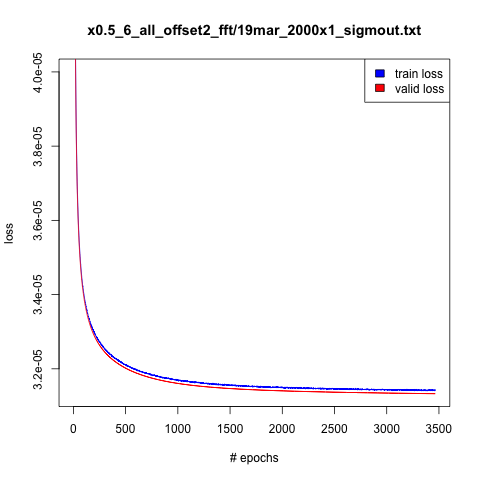

In [13]:
%%R
df = read.csv("../models/x0.5_6_all_offset2_fft/19mar_2000x1_sigmout.txt")

plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="x0.5_6_all_offset2_fft/19mar_2000x1_sigmout.txt",
    ylim=c(  min( min(df$train_loss), min(df$valid_loss) ) , 4e-05 )  )
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))

In [15]:
%%R
log(0.001)

[1] -6.907755
